# E-commerce Customer Purchase Prediction

This Notebook predicts Customer Purchase pattern based on online shoppers intention dataset.

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import chi2_contingency, jarque_bera, normaltest
import itertools
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Target distribution:\n{df['Revenue'].value_counts()}")
print(f"Target percentage:\n{df['Revenue'].value_counts(normalize=True)*100}")

Dataset shape: (12330, 18)
Missing values: 0
Duplicate rows: 125
Target distribution:
Revenue
False    10422
True      1908
Name: count, dtype: int64
Target percentage:
Revenue
False    84.525547
True     15.474453
Name: proportion, dtype: float64


# Data Overview

In [3]:
df.info()
print("\nNumerical columns statistics:")
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(df[numerical_cols].describe())

print("\nCategorical columns:")
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())
    print("-" * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# Data Quality Assessment

In [4]:
def data_quality_report(dataframe):
    report = {}
    for col in dataframe.columns:
        col_data = dataframe[col]
        report[col] = {
            'dtype': str(col_data.dtype),
            'missing_count': col_data.isnull().sum(),
            'missing_percentage': (col_data.isnull().sum() / len(col_data)) * 100,
            'unique_count': col_data.nunique(),
            'duplicate_count': col_data.duplicated().sum()
        }

        if col_data.dtype in ['int64', 'float64']:
            report[col].update({
                'mean': col_data.mean(),
                'std': col_data.std(),
                'min': col_data.min(),
                'max': col_data.max(),
                'skewness': col_data.skew(),
                'kurtosis': col_data.kurtosis(),
                'zeros_count': (col_data == 0).sum(),
                'outliers_iqr': len(col_data[(col_data < (col_data.quantile(0.25) - 1.5 * (col_data.quantile(0.75) - col_data.quantile(0.25)))) |
                                           (col_data > (col_data.quantile(0.75) + 1.5 * (col_data.quantile(0.75) - col_data.quantile(0.25))))])
            })

    return pd.DataFrame(report).T

quality_report = data_quality_report(df)
print("Data Quality Report:")
print(quality_report)

Data Quality Report:
                           dtype missing_count missing_percentage  \
Administrative             int64             0                0.0   
Administrative_Duration  float64             0                0.0   
Informational              int64             0                0.0   
Informational_Duration   float64             0                0.0   
ProductRelated             int64             0                0.0   
ProductRelated_Duration  float64             0                0.0   
BounceRates              float64             0                0.0   
ExitRates                float64             0                0.0   
PageValues               float64             0                0.0   
SpecialDay               float64             0                0.0   
Month                     object             0                0.0   
OperatingSystems           int64             0                0.0   
Browser                    int64             0                0.0   
Region       

# Visualization Dashboard - Distribution Analysis

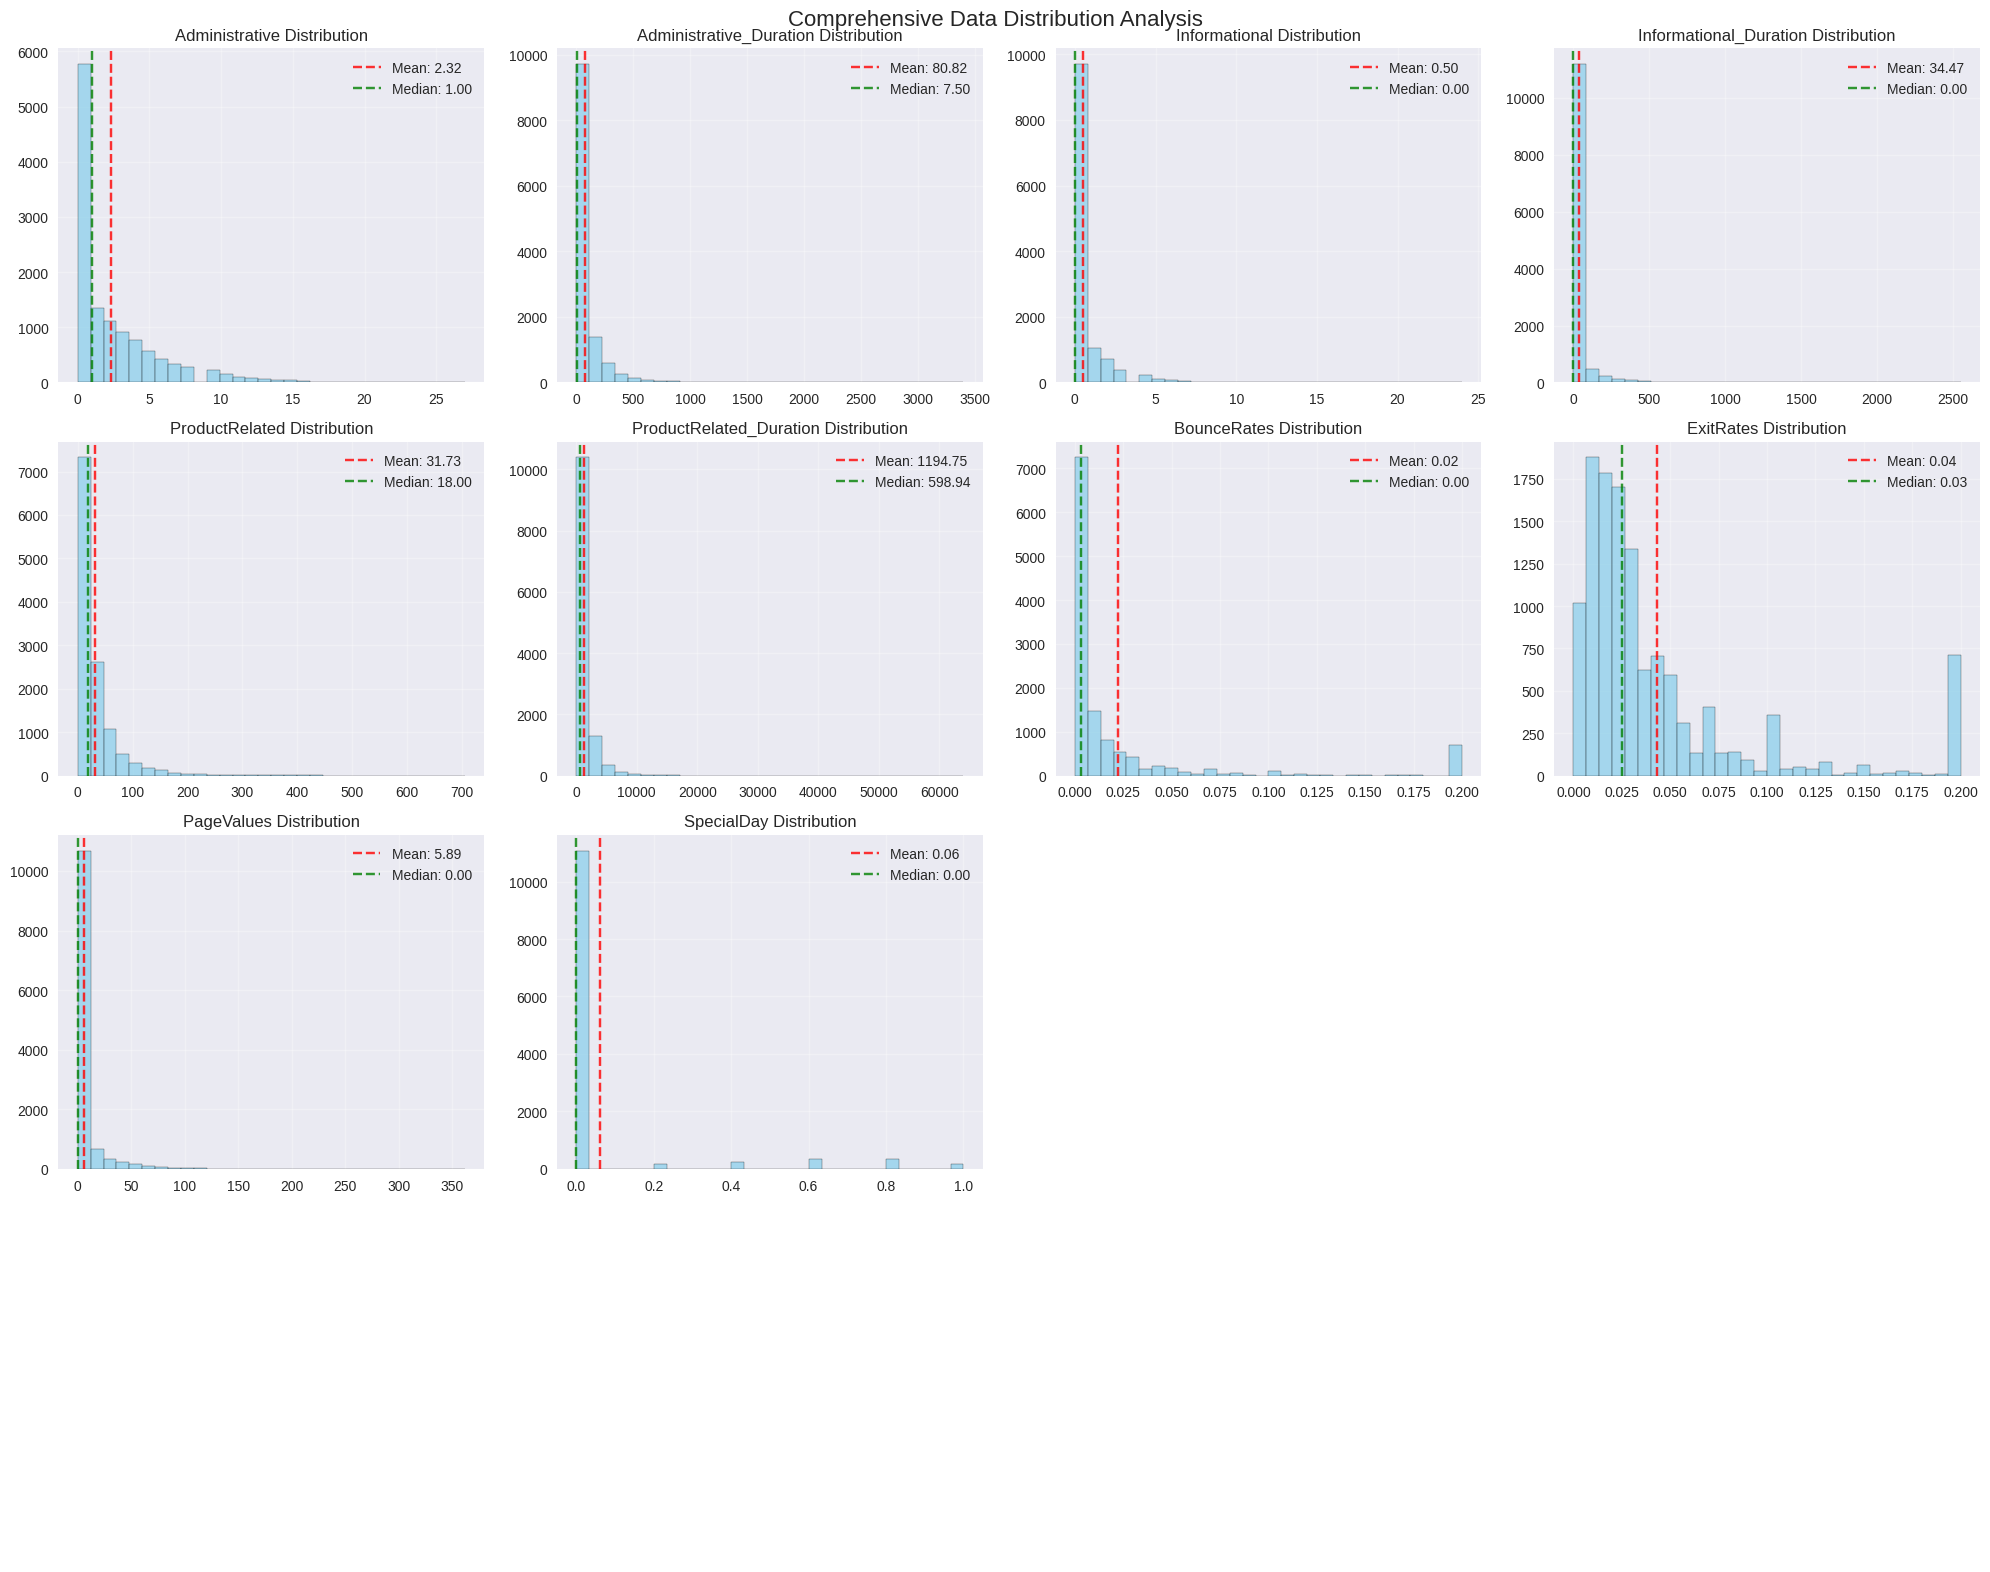

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Comprehensive Data Distribution Analysis', fontsize=16, y=0.98)

numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                     'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
                     'PageValues', 'SpecialDay']

for i, feature in enumerate(numerical_features):
    row, col = i // 4, i % 4
    axes[row, col].hist(df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col].axvline(df[feature].mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean: {df[feature].mean():.2f}')
    axes[row, col].axvline(df[feature].median(), color='green', linestyle='--', alpha=0.8, label=f'Median: {df[feature].median():.2f}')
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

for i in range(len(numerical_features), 16):
    row, col = i // 4, i % 4
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Correlation Analysis and Heatmap

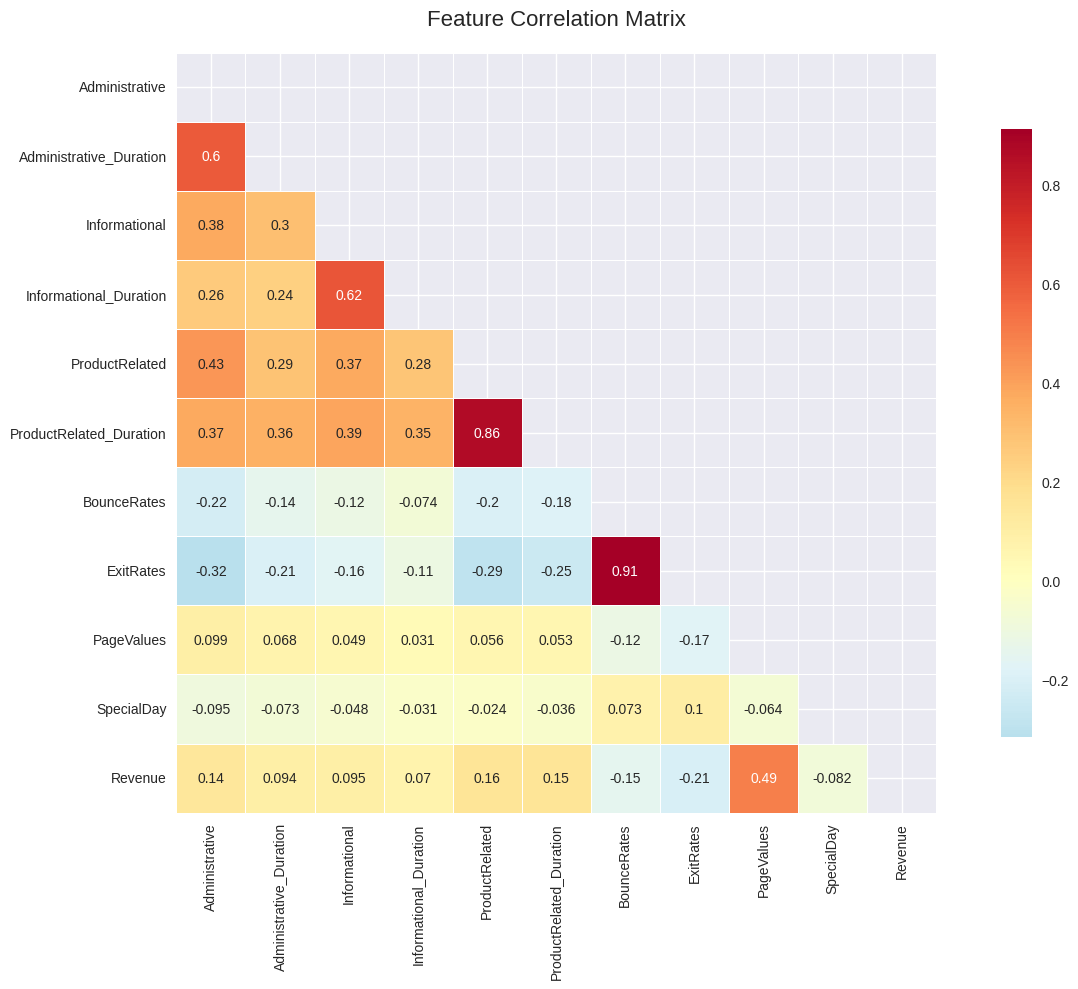

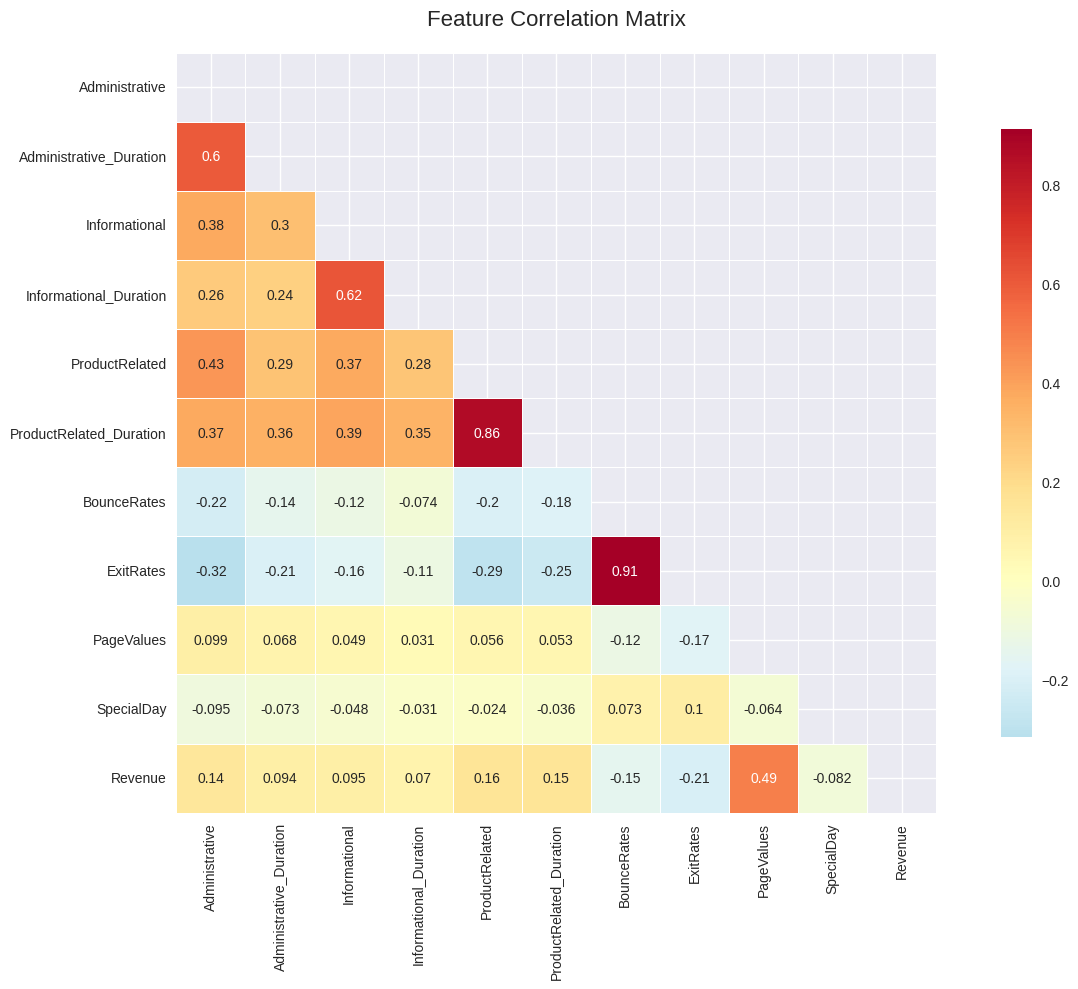

In [6]:
correlation_matrix = df[numerical_features + ['Revenue']].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                     square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

correlation_matrix = df[numerical_features + ['Revenue']].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                     square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Statistical Significance Testing

In [7]:
def perform_statistical_tests(dataframe, target_col):
    results = {}
    target = dataframe[target_col]

    for col in dataframe.select_dtypes(include=[np.number]).columns:
        if col != target_col:
            group_0 = dataframe[target == False][col]
            group_1 = dataframe[target == True][col]

            t_stat, t_pval = stats.ttest_ind(group_0, group_1)

            u_stat, u_pval = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')

            ks_stat, ks_pval = stats.ks_2samp(group_0, group_1)

            results[col] = {
                't_statistic': t_stat,
                't_pvalue': t_pval,
                'mannwhitney_statistic': u_stat,
                'mannwhitney_pvalue': u_pval,
                'ks_statistic': ks_stat,
                'ks_pvalue': ks_pval
            }

    return pd.DataFrame(results).T

statistical_results = perform_statistical_tests(df, 'Revenue')
print("Statistical Test Results (p-values < 0.05 indicate significant differences):")
print(statistical_results.round(6))

Statistical Test Results (p-values < 0.05 indicate significant differences):
                         t_statistic  t_pvalue  mannwhitney_statistic  \
Administrative            -15.575194  0.000000              7421135.5   
Administrative_Duration   -10.436882  0.000000              7487115.0   
Informational             -10.618467  0.000000              8648742.0   
Informational_Duration     -7.829854  0.000000              8711649.0   
ProductRelated            -17.828190  0.000000              6792127.0   
ProductRelated_Duration   -17.118049  0.000000              6502463.0   
BounceRates                16.922638  0.000000             12198493.0   
ExitRates                  23.500777  0.000000             13981307.0   
PageValues                -62.843162  0.000000              2718419.0   
SpecialDay                  9.169515  0.000000             10665043.0   
OperatingSystems            1.628737  0.103394             10337403.0   
Browser                    -2.663779  0.007737 